In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import requests
sns.set()

## Pull sentiment, fear greed and BTC/USDT data from bitcurate API.

Can read more about this API at https://doc.api.bitcurate.com/

In [2]:
r = requests.get('https://datascience.api.dev.bitcurate.com/social_sentiment?query=(BTC%20OR%20bitcoin)%20AND%20binance&before_date=8/15/2019%200:0')
sentiment = r.json()
sentiment.keys()

dict_keys(['momentum', 'sentiment', 'timestamp', 'volatility'])

In [3]:
r = requests.get('https://datascience.api.dev.bitcurate.com/social_feargreed?query=(BTC%20OR%20bitcoin)%20AND%20binance&before_date=8/15/2019%200:0')
feargreed = r.json()
feargreed.keys()

dict_keys(['fear', 'greed', 'label', 'timestamp'])

In [4]:
r = requests.get('https://datascience.api.dev.bitcurate.com/pair?before_date=8/15/2019%200:0&pair=BTC/USDT&exchange=binance')
btc = r.json()
btc.keys()

dict_keys(['close', 'high', 'low', 'momentum', 'open', 'timestamp', 'volatility', 'volume'])

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


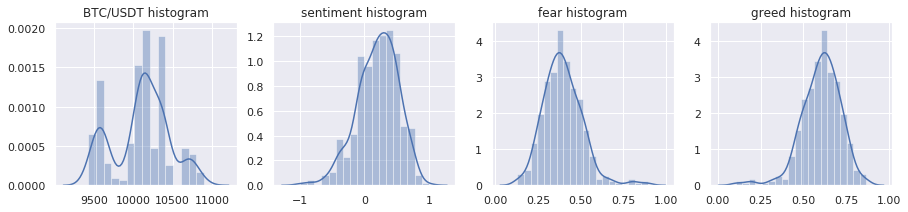

In [5]:
plt.figure(figsize=(15,3))
plt.subplot(1,4,1)
sns.distplot(btc['close'])
plt.title('BTC/USDT histogram')
plt.subplot(1,4,2)
sns.distplot(sentiment['sentiment'])
plt.title('sentiment histogram')
plt.subplot(1,4,3)
sns.distplot(feargreed['fear'])
plt.title('fear histogram')
plt.subplot(1,4,4)
sns.distplot(feargreed['greed'])
plt.title('greed histogram')
plt.show()

In [6]:
df_sentiment = pd.DataFrame(sentiment)
df_btc = pd.DataFrame(btc)
df_feargreed = pd.DataFrame(feargreed)
merged = df_sentiment.merge(df_btc, on = 'timestamp')
merged = merged.merge(df_feargreed, on = 'timestamp')
merged.head()

,momentum_x,sentiment,timestamp,volatility_x,close,high,low,momentum_y,open,volatility_y,volume,fear,greed,label
0,1.726086,-0.305778,2019-08-15 00:00:00,70.186031,10142.664026,10854.806026,9928.099609,96.233277,10843.803747,0.005316,5.790672e+08,0.497674,0.502326,greed
1,1.726086,0.184823,2019-08-15 01:00:00,70.186031,10086.199284,10739.315820,9928.099609,96.233277,10689.825716,0.005316,5.641456e+08,0.801826,0.198174,fear
2,1.726086,0.726358,2019-08-15 02:00:00,70.186031,10095.049805,10712.450195,9928.099609,96.233277,10611.636387,0.005316,5.416016e+08,0.809082,0.190918,fear
3,1.726086,0.100070,2019-08-15 03:00:00,70.186031,10095.049805,10697.000000,9928.099609,96.233277,10640.818994,0.005316,5.159930e+08,0.320567,0.679433,greed
4,1.726086,0.219240,2019-08-15 04:00:00,70.186031,10095.049805,10697.000000,9928.099609,96.233277,10642.563684,0.005316,5.106988e+08,0.381714,0.618286,greed


## Monte carlo simulation using sentiment and fear

I want to simulate 30 hours ahead for 100 times. More simulation, more precise it will be.

In [7]:
number_simulation = 100
predict_hour = 30

In [8]:
v = merged[['sentiment', 'fear', 'close']].pct_change(1).dropna().values
variance = np.linalg.cholesky(np.cov(v.T))
daily_vol = np.sqrt(variance)
avg_daily_ret = np.mean(v,axis=0)
daily_drift = avg_daily_ret - (variance / 2)
drift = daily_drift - 0.5 * daily_vol ** 2

results_close_fear = pd.DataFrame()

for i in tqdm(range(number_simulation)):
    prices = []
    prices.append(merged['close'].iloc[-1])
    for d in range(predict_hour):
        shock = drift + daily_vol * np.random.normal()
        price = prices[-1] * np.exp(shock)[-1,-1]
        prices.append(price)
    results_close_fear[i] = prices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████| 100/100 [00:00<00:00, 1995.27it/s]


## Monte carlo simulation using sentiment and greed

In [9]:
number_simulation = 100
predict_hour = 30
v = merged[['sentiment', 'greed', 'close']].pct_change(1).dropna().values
variance = np.linalg.cholesky(np.cov(v.T))
daily_vol = np.sqrt(variance)
avg_daily_ret = np.mean(v,axis=0)
daily_drift = avg_daily_ret - (variance / 2)
drift = daily_drift - 0.5 * daily_vol ** 2

results_close_greed = pd.DataFrame()

for i in tqdm(range(number_simulation)):
    prices = []
    prices.append(merged['close'].iloc[-1])
    for d in range(predict_hour):
        shock = drift + daily_vol * np.random.normal()
        price = prices[-1] * np.exp(shock)[-1,-1]
        prices.append(price)
    results_close_greed[i] = prices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in sqrt
  """
100%|██████████| 100/100 [00:00<00:00, 1956.93it/s]


## Monte carlo simulation univariate

**Just historical close volatility, univariate**.

In [10]:
number_simulation = 100
predict_hour = 30

close = merged['close'].tolist()
returns = pd.DataFrame(close).pct_change()
last_price = close[-1]
results = pd.DataFrame()
avg_daily_ret = returns.mean()
variance = returns.var()
daily_vol = returns.std()
daily_drift = avg_daily_ret - (variance / 2)
drift = daily_drift - 0.5 * daily_vol ** 2

results = pd.DataFrame()

for i in tqdm(range(number_simulation)):
    prices = []
    prices.append(merged['close'].iloc[-1])
    for d in range(predict_hour):
        shock = drift + daily_vol * np.random.normal()
        price = prices[-1] * np.exp(shock)
        prices.append(price[0])
    results[i] = prices

100%|██████████| 100/100 [00:01<00:00, 79.04it/s]


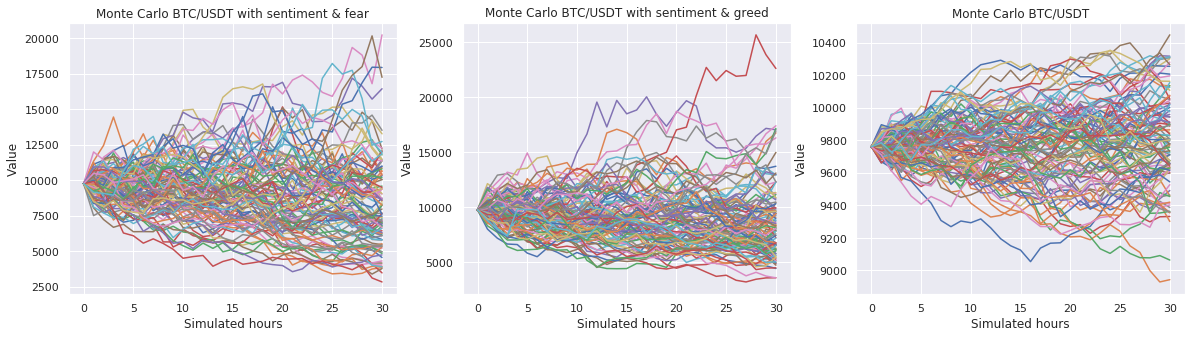

In [11]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.plot(results_close_fear)
plt.ylabel('Value')
plt.xlabel('Simulated hours')
plt.title('Monte Carlo BTC/USDT with sentiment & fear')
plt.subplot(1,3,2)
plt.plot(results_close_greed)
plt.ylabel('Value')
plt.xlabel('Simulated hours')
plt.title('Monte Carlo BTC/USDT with sentiment & greed')
plt.subplot(1,3,3)
plt.plot(results)
plt.ylabel('Value')
plt.xlabel('Simulated hours')
plt.title('Monte Carlo BTC/USDT')
plt.show()

## Value-at-Risk

In [12]:
price_array = results_close_fear.iloc[-1, :]
price_array = sorted(price_array, key = int)
var99 = np.percentile(price_array, 0.99)
print('99% VaR for sentiment & fear:', var99)

price_array = results_close_greed.iloc[-1, :]
price_array = sorted(price_array, key = int)
var99 = np.percentile(price_array, 0.99)
print('99% VaR for sentiment & greed:', var99)

price_array = results.iloc[-1, :]
price_array = sorted(price_array, key = int)
var99 = np.percentile(price_array, 0.99)
print('99% VaR:', var99)

99% VaR for sentiment & fear: 3460.0421119349726
99% VaR for sentiment & greed: 3587.808611402619
99% VaR: 9061.239256181689


**If you observed from both `fear` and `greed` histograms, some of simulations dropped less than 5k of `BTC/USDT`. What is the probability going to happen for going less than 5k based on the monte carlo?**

In [13]:
v = results_close_fear.iloc[-1, :].values
print('probability < 5k for sentiment & fear', v[v < 5000].shape[0] / number_simulation)
v = results_close_greed.iloc[-1, :].values
print('probability < 5k for sentiment & greed', v[v < 5000].shape[0] / number_simulation)

probability < 5k for sentiment & fear 0.14
probability < 5k for sentiment & greed 0.09


I believe it is pretty reasonable why probability on `fear` is higher than `greed`, `fear` factors can caused bearish.

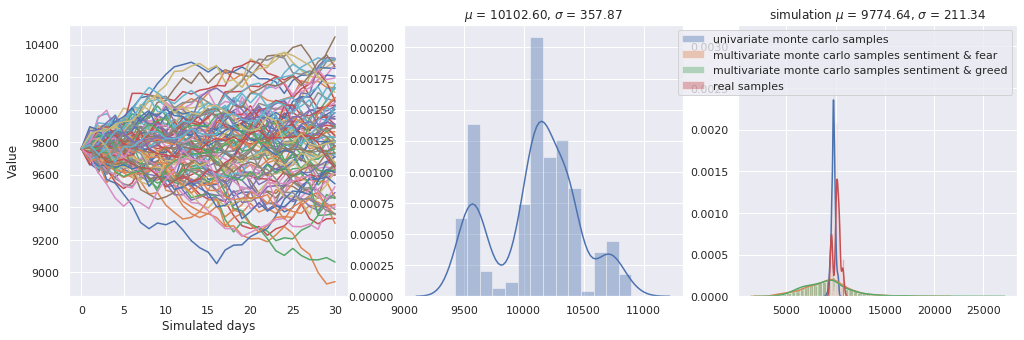

In [14]:
raveled = results.values.ravel()
raveled.sort()
cp_raveled = raveled.copy()

raveled_close_fear = results_close_fear.values.ravel()
raveled_close_fear.sort()
cp_raveled_close_fear = raveled_close_fear.copy()

raveled_close_greed = results_close_greed.values.ravel()
raveled_close_greed.sort()
cp_raveled_close_greed = raveled_close_greed.copy()

plt.figure(figsize=(17,5))
plt.subplot(1,3,1)
plt.plot(results)
plt.ylabel('Value')
plt.xlabel('Simulated days')
plt.subplot(1,3,2)
sns.distplot(close,norm_hist=True)
plt.title('$\mu$ = %.2f, $\sigma$ = %.2f'%(np.mean(close),np.std(close)))
plt.subplot(1,3,3)
sns.distplot(raveled,norm_hist=True,label='univariate monte carlo samples')
sns.distplot(raveled_close_fear,norm_hist=True,label='multivariate monte carlo samples sentiment & fear')
sns.distplot(raveled_close_greed,norm_hist=True,label='multivariate monte carlo samples sentiment & greed')
sns.distplot(close,norm_hist=True,label='real samples')
plt.title('simulation $\mu$ = %.2f, $\sigma$ = %.2f'%(raveled.mean(),raveled.std()))
plt.legend()
plt.show()